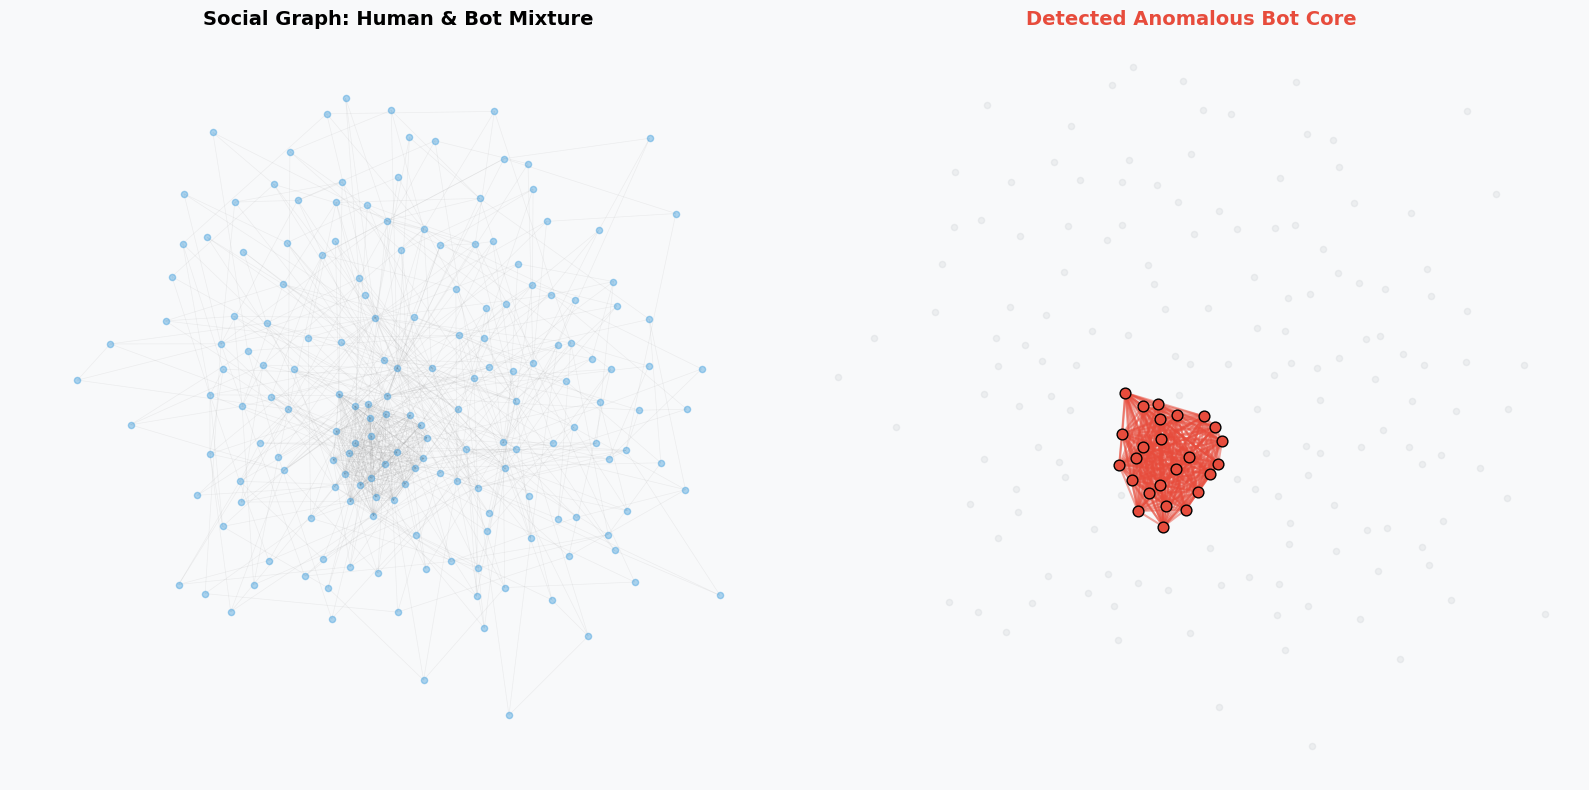

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# 1. GENERATING A REALISTIC SOCIAL GRAPH
num_humans = 150
num_bots = 25

# Create an organic human network using Power-Law (Scale-Free)
# This takes into account people who have many connections and others who have few
human_network = nx.powerlaw_cluster_graph(n=num_humans, m=3, p=0.1, seed=42)

# Create a bot 'Sybil' cluster 
# Real bots follow each other to boost their K-Core rank
bot_network = nx.complete_graph(num_bots)
bot_network = nx.relabel_nodes(bot_network, {i: i + num_humans for i in range(num_bots)})

# Merge them
combined_network = nx.compose(human_network, bot_network)

# Bots follow each other, but also follow humans to appear authentic
for bot in range(num_humans, num_humans + num_bots):
    targets = random.sample(range(num_humans), k=3)
    for t in targets:
        combined_network.add_edge(bot, t)

# 2. THE K-CORE LOGIC
def get_k_core(graph, k):
    adj = {node: set(neighbors) for node, neighbors in graph.adjacency()}
    while True:
        to_remove = [node for node, neighbors in adj.items() if len(neighbors) < k]
        if not to_remove: break 
        for node in to_remove:
            for neighbor in adj[node]:
                adj[neighbor].remove(node)
            del adj[node]
    return nx.Graph(adj)

# 3. RUN DETECTION
# Higher K identifies the 'densest' coordinated cores
bot_core = get_k_core(combined_network, k=12)

# 4. VISUALIZATION
def draw_professional_comparison(G, core_G):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), facecolor='#F8F9FA')
    
    # Layout for a cleaner look
    pos = nx.spring_layout(G, k=0.15, seed=42)
    
    # Left: Original Network with styling
    nx.draw_networkx_nodes(G, pos, node_size=20, node_color='#3498db', alpha=0.4, ax=ax1)
    nx.draw_networkx_edges(G, pos, width=0.5, edge_color='grey', alpha=0.1, ax=ax1)
    ax1.set_title("Social Graph: Human & Bot Mixture", fontsize=14, fontweight='bold')
    ax1.axis('off')

    # Right: The Detection (Highlighting the core)
    # Highlight detected core in red
    nx.draw_networkx_nodes(G, pos, node_size=20, node_color='#bdc3c7', alpha=0.2, ax=ax2)
    nx.draw_networkx_nodes(core_G, pos, node_size=60, node_color='#e74c3c', edgecolors='black', ax=ax2)
    nx.draw_networkx_edges(core_G, pos, width=1.5, edge_color='#e74c3c', alpha=0.5, ax=ax2)
    ax2.set_title("Detected Anomalous Bot Core", fontsize=14, fontweight='bold', color='#e74c3c')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

draw_professional_comparison(combined_network, bot_core)

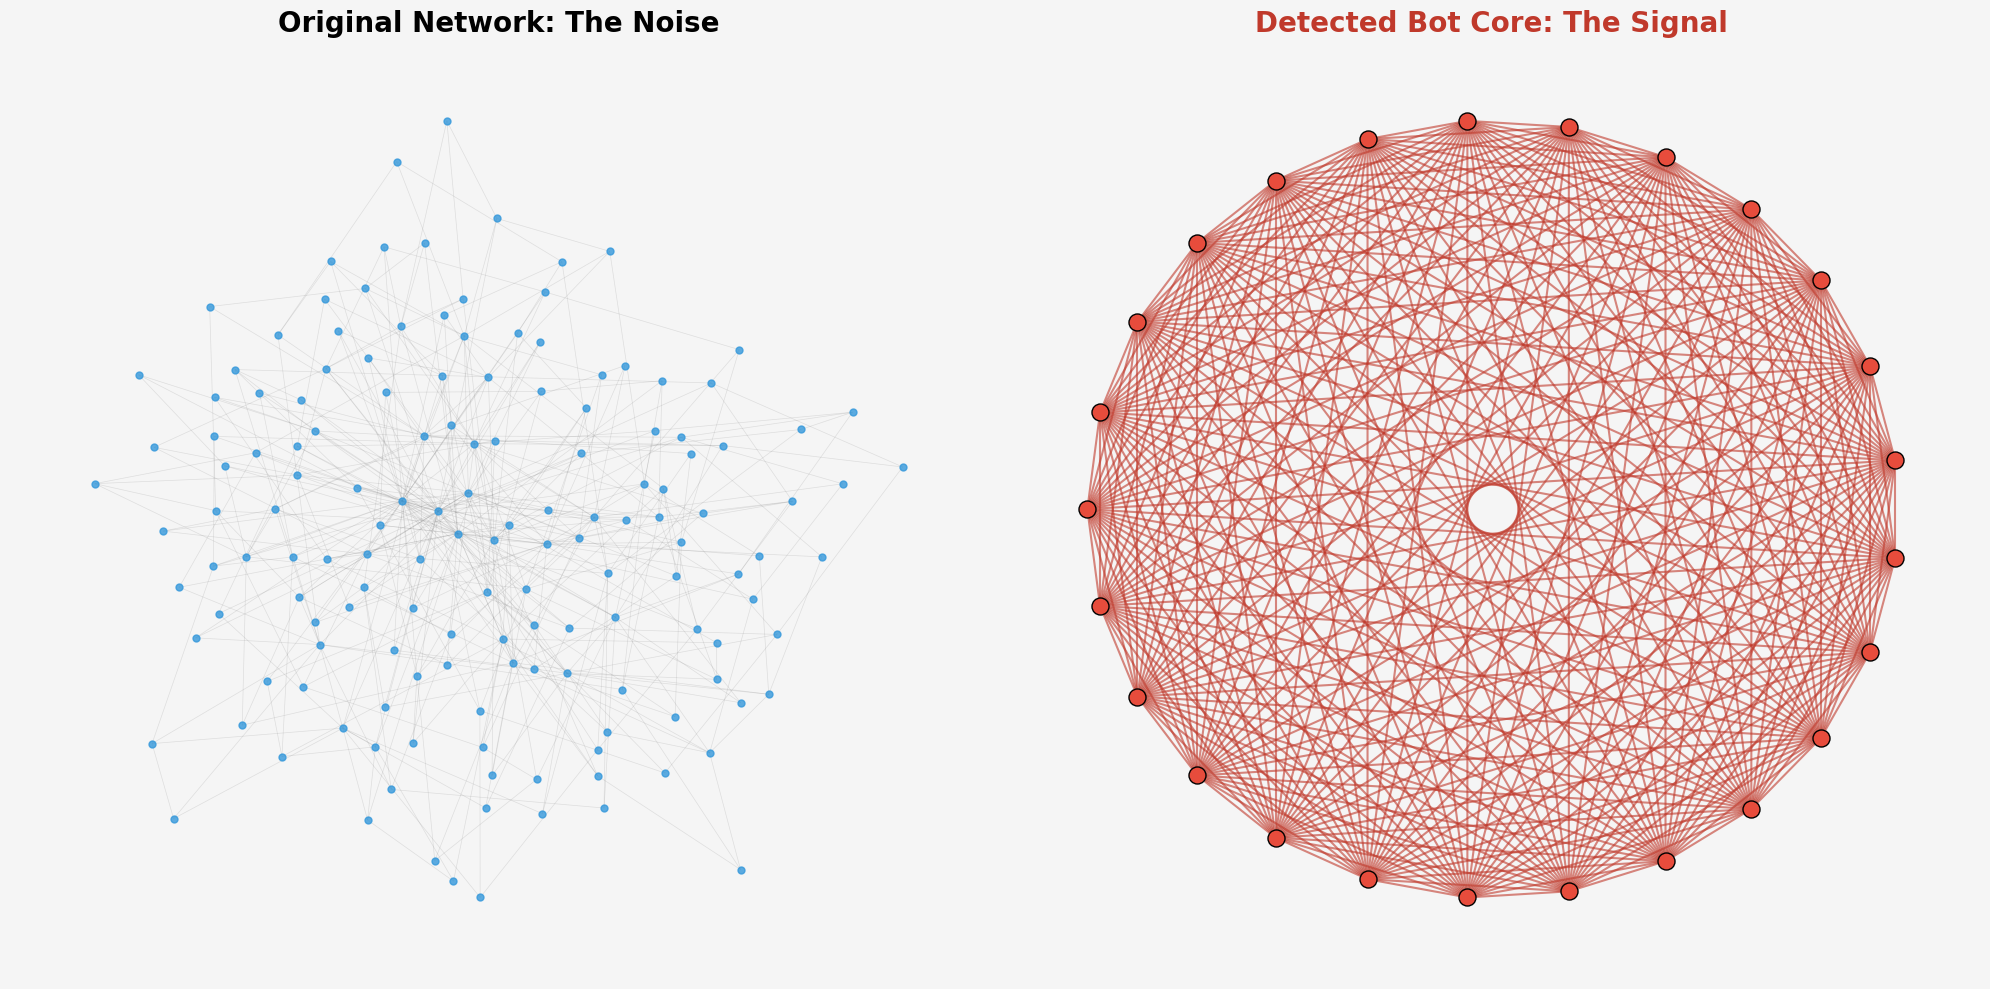

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_clean_comparison(original_G, core_G):
    # Create a figure with a dark, professional background
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), facecolor='#F5F5F5')
    
    # Use 'Spring Layout' to position nodes further apart to see the "structure"
    pos_orig = nx.spring_layout(original_G, k=0.15, iterations=50, seed=42)
    pos_core = nx.shell_layout(core_G) # Shell layout looks much cleaner for cliques
    
    # Draw Original Network
    nx.draw_networkx_nodes(original_G, pos_orig, node_size=25, 
                           node_color='#3498db', alpha=0.8, ax=ax1)
    nx.draw_networkx_edges(original_G, pos_orig, width=0.5, 
                           edge_color='grey', alpha=0.2, ax=ax1) # Low alpha = cleaner
    ax1.set_title("Original Network: The Noise", fontsize=20, fontweight='bold')
    ax1.axis('off')

    # Draw Bot Clique
    nx.draw_networkx_nodes(core_G, pos_core, node_size=150, 
                           node_color='#e74c3c', edgecolors='black', ax=ax2)
    nx.draw_networkx_edges(core_G, pos_core, width=1.5, 
                           edge_color='#c0392b', alpha=0.6, ax=ax2)
    ax2.set_title("Detected Bot Core: The Signal", fontsize=20, fontweight='bold', color='#c0392b')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

# Run visualization
draw_clean_comparison(human_network, bot_core)

In [3]:
import networkx as nx

file_path = "twitter_combined.txt"  # File path for functional Twitter dataset

def load_twitter_data(file_path):
    print("Loading Twitter data from:", file_path) # Loading Standford SNAP Dataset information by Jure Leskovec
    print("Opening file")
    # Using nx.read_edgelist to optimize space
    # Twitter file uses spaces between IDs
    twitter_graph = nx.read_edgelist(file_path, create_using=nx.Graph(), nodetype=int)
    return twitter_graph


In [4]:
twitter_network  = load_twitter_data(file_path)

print("Successfully loaded", twitter_network.number_of_nodes(), "users")
print("Successfully loaded", twitter_network.number_of_edges(), "connections")

Loading Twitter data from: twitter_combined.txt
Opening file
Successfully loaded 81306 users
Successfully loaded 1342310 connections


In [5]:
import multiprocessing as mp
import networkx as nx

def find_nodes_to_remove(node_chunk, adj_dictionary, k):
    #Looks at a chunk of nodes at a time and finds which ones have <k connections
    return [node for node in node_chunk if len(adj_dictionary[node]) < k]

def get_k_core_parallel(graph, k):
    adj = {node: set(neighbors) for node, neighbors in graph.adjacency()} # Convert to a dictionary adjacency list for speed O(1) lookup time
    nodes = list(adj.keys())
    num_cores = mp.cpu_count() # Gets number of CPU cores available
    #print("Using {num_cores} CPU cores for parallel processing")
    while True:
        # Split the nodes into chunks so each core processes a chunk, resulting in faster processing
        chunk_size = len(nodes) // num_cores # Find chunk size
        chunks = [nodes[i:i + chunk_size] for i in range(0, len(nodes), chunk_size)] # Start at index i and go up to i + chunk_size
        #Chunk 1: nodes[0,chunk_size], Chunk 2: nodes[chunk_size+1, 2*chunk_size], etc.

        # Now parallel the processing
        with mp.Pool(processes = num_cores) as pool:
            results = pool.starmap(find_nodes_to_remove, [(chunk, adj, k) for chunk in chunks]) # Each core processes its designated chunk
        
        nodes_to_remove = [node for sublist in results for node in sublist] # Project the list of lists into a single list of suspected bots

        # if there are no suspected bots return early, otherwise continue
        if not nodes_to_remove:
            break

        for node in nodes_to_remove: # Loop through each suspected bot
            if node in adj: # Check if node exists, it could have already been removed by another neighbor
                for neighbor in adj[node]: # Tell neighbors to remove node from their adj list
                    if node in adj[neighbor]:   
                        adj[neighbor].remove(node)
                del adj[node] # Once neighbors have deleted the node, delete the node itself

        nodes = list(adj.keys()) # Upate remaining nodes
        print("Nodes remaining:", len(nodes))
    return nx.Graph(adj) # Convert back to NetworkX for visualization

In [6]:
import json

bot_list = list(bot_core.nodes())
with open("detected_bots.json", "w") as f:
    json.dump(bot_list, f)
print("Saved", {len(bot_list)}, "bot IDs to detected_bots.json")

Saved {25} bot IDs to detected_bots.json
